In [25]:
import scipy.io
import scipy.ndimage
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy import sparse
import matplotlib.pyplot as plt
from functools import partial

import torch
from Solver import *
# from NeuralNet import *
from timeit import default_timer

import sys
sys.path.append('../Utility')
import NeuralNet


In [26]:
def ref_permeability(q, dq):
    return np.sqrt(q**2 + dq**2) 
def D_ref_permeability(q, dq):
    return q/np.sqrt(q**2 + dq**2), dq/np.sqrt(q**2 + dq**2)


# Training a quadratic function
 $$D(\theta) = \sqrt{\theta^2 + (\frac{\partial \theta}{\partial x})^2}$$

In [27]:
nn_save_name = "quadratic.nn"
N_train_1d = 100
L_train_1d = 1
N_train = N_train_1d**2

x_train_1d = np.linspace(-L_train_1d, L_train_1d, N_train_1d)
X_train_2d, Y_train_2d = np.meshgrid(x_train_1d, x_train_1d)


x_train = np.vstack((X_train_2d.reshape(-1), Y_train_2d.reshape(-1))).T
y_train = ref_permeability(x_train[:, 0], x_train[:, 1]).reshape((N_train, 1))
    
x_train = torch.from_numpy(x_train.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))

ind = x_train.shape[1]
outd = y_train.shape[1] 

learning_rate = 0.001
step_size = 100
gamma = 0.5  
epochs = 1000
batch_size = 64

layers = 2
width  = 20
activation='relu'
initializer='default'
outputlayer='None'

net = NeuralNet.FNN(ind, outd, layers, width, activation, initializer, outputlayer) 

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)

optimizer = NeuralNet.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

myloss = torch.nn.MSELoss(reduction='sum')
t0 = default_timer()
for ep in range(epochs):
    net.train()
    t1 = default_timer()
    train_l2 = 0
    for x, y in train_loader:

        optimizer.zero_grad()
        out = net(x)
        
        loss = myloss(out , y)*100
        loss.backward()

        optimizer.step()
        train_l2 += loss.item()

#     scheduler.step()

    if ep % 100 == 0:
        # train_l2/= ntrain
        t2 = default_timer()
        print("Epoch : ", ep, " Epoch time : ", t2-t1, " Train L2 Loss : ", train_l2)
        if nn_save_name is not None:
            torch.save(net, nn_save_name)
        


Epoch :  0  Epoch time :  0.20340637500339653  Train L2 Loss :  55247.551151275635
Epoch :  100  Epoch time :  0.11299662401142996  Train L2 Loss :  5.562258413992822
Epoch :  200  Epoch time :  0.11242301600577775  Train L2 Loss :  4.65396492369473
Epoch :  300  Epoch time :  0.11361915900488384  Train L2 Loss :  4.704455123282969
Epoch :  400  Epoch time :  0.2215156339952955  Train L2 Loss :  4.128394532948732
Epoch :  500  Epoch time :  0.22497893800027668  Train L2 Loss :  4.890653918031603
Epoch :  600  Epoch time :  0.23699934600153938  Train L2 Loss :  4.63322829362005
Epoch :  700  Epoch time :  0.23722026200266555  Train L2 Loss :  4.283243319019675
Epoch :  800  Epoch time :  0.23563175200251862  Train L2 Loss :  4.074062397936359
Epoch :  900  Epoch time :  0.23217437700077426  Train L2 Loss :  4.195723159238696


# Testing on the quadratic function

In [28]:
N_test_1d = 200
L_test_1d = 1
N_test = N_test_1d**2

x_test_1d = np.linspace(-L_test_1d, L_test_1d, N_test_1d)
X_test_2d, Y_test_2d = np.meshgrid(x_test_1d, x_test_1d)

x_test = np.vstack((X_test_2d.reshape(-1), Y_test_2d.reshape(-1))).T    
y_test = ref_permeability(x_test[:, 0], x_test[:, 1]).reshape((N_test, 1))



x_test = torch.from_numpy(x_test.astype(np.float32))
y_pred = net_eval(net, x_test)



/central/home/dzhuang/Code/Point-Jet/Poisson_model/Solver.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return net(torch.tensor(x, dtype=torch.float32)).detach().numpy().flatten()


/tmp/ipykernel_188171/4190918090.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X_test_2d, Y_test_2d, y_test_2d)
/tmp/ipykernel_188171/4190918090.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X_test_2d, Y_test_2d, y_pred_2d)
/tmp/ipykernel_188171/4190918090.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrila

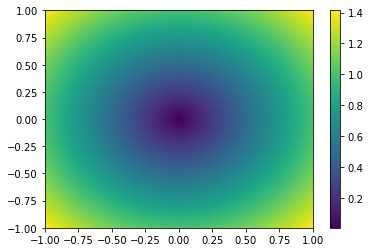

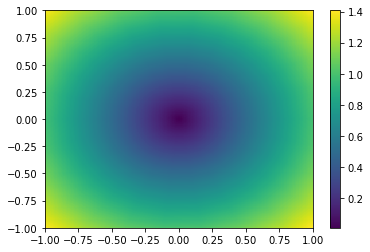

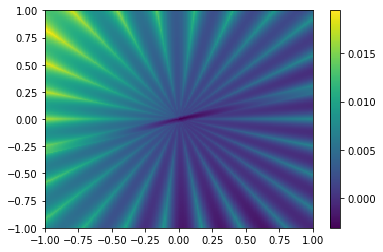

In [29]:
y_test_2d = y_test.reshape((N_test_1d,N_test_1d))
y_pred_2d = y_pred.reshape((N_test_1d,N_test_1d))

plt.figure()
plt.pcolormesh(X_test_2d, Y_test_2d, y_test_2d)
plt.colorbar()

plt.figure()
plt.pcolormesh(X_test_2d, Y_test_2d, y_pred_2d)
plt.colorbar()

plt.figure()
plt.pcolormesh(X_test_2d, Y_test_2d, y_test_2d - y_pred_2d)
plt.colorbar()

# Derivative test

In [17]:
q = np.array([1.0])
dq = np.array([1.0])
x = torch.from_numpy((np.vstack((q, dq)).T).astype(np.float32))  
x.requires_grad = True
y = net(x)  #.detach().numpy().flatten()

d = torch.autograd.grad(y, x)

print("analytical derivative is :", d)
eps = 1e-3
xp0 = x + torch.Tensor([eps, 0.0])
yp0 = net(xp0)
xp1 = x + torch.Tensor([0.0, eps])
yp1 = net(xp1)

print("FD derivative is :", (yp0-y)/eps, (yp1-y)/eps)


analytical derivative is : (tensor([[0.6813, 0.6986]]),)
FD derivative is : tensor([[0.6814]], grad_fn=<DivBackward0>) tensor([[0.6987]], grad_fn=<DivBackward0>)


# Plug-in test

100000 max q 0.3612968630051589
200000 max q 0.3833724143438851
300000 max q 0.3838681017323774
400000 max q 0.3838789824417029
500000 max q 0.38387922115718404
100000 max q 0.3612248943413314
200000 max q 0.38325022690769084
300000 max q 0.3837435501823903
400000 max q 0.3837543546843607
500000 max q 0.38375459243274934


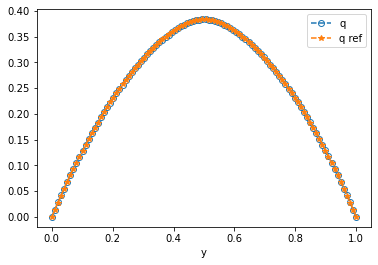

In [18]:
L = 1.0
Ny = 100
yy = np.linspace(0.0, L, Ny)
f = 6*(1-2*yy)**2 - 2*(yy - yy**2)*(1 - 2*yy)**2 + 2*(yy - yy**2)**2 + 2 
q_sol = -yy*(yy - 1)
dbc = np.array([0.0, 0.0]) 

MODEL = "exp_nummodel"

nn_model = partial(nn_permeability, net)
D_nn_model = partial(D_nn_permeability, net)

if MODEL == "exp_nummodel":
    
    model = lambda q, yy, res : nummodel(ref_permeability, q, yy, res)
    yy, t_data_ref, q_data_ref = explicit_solve(model, f, dbc, dt = 2.0e-6, Nt = 500000, save_every = 100000, L = L)
    
    
    model = lambda q, yy, res : nummodel(nn_model, q, yy, res)
    yy, t_data, q_data = explicit_solve(model, f, dbc, dt = 2.0e-6, Nt = 500000, save_every = 100000, L = L)

elif MODEL == "imp_nummodel":
    
    model = lambda q, yy, res, V : nummodel_jac(ref_permeability, q, yy, res, V, True, D_ref_permeability)  
    yy_ref, t_data_ref, q_data_ref = implicit_solve(model, f, dbc, dt = 1.0e-3, Nt = 200, save_every = 100, L = L)
    
    model = lambda q, yy, res, V : nummodel_jac(nn_model, q, yy, res, V, True, D_permeability)  
    yy, t_data, q_data = implicit_solve(model, f, dbc, dt = 1.0e-3, Nt = 200, save_every = 100, L = L)
    
elif MODEL == "imp_Newton_nummodel":
    
    model = lambda q, yy, res, V : nummodel_jac(ref_permeability, q, yy, res, V, True, D_ref_permeability)  
    yy_ref, t_data_ref, q_data_ref = implicit_Newton_solve(model, f, dbc, dt = 1.0e-3, Nt = 200, save_every = 100, L = L, Newton_eps = 1e-3, Newton_maxiterstep = 1000)
    
    model = lambda q, yy, res, V : nummodel_jac(nn_model, q, yy, res, V, True, D_permeability)  
    yy, t_data, q_data = implicit_Newton_solve(model, f, dbc, dt = 1.0e-3, Nt = 200, save_every = 100, L = L, Newton_eps = 1e-3, Newton_maxiterstep = 1000)
    
else:
    print("ERROR")


plt.figure()
plt.plot(yy, q_data[-1, :],  "--o", fillstyle="none", label="q")
plt.plot(yy, q_data_ref[-1, :],  "--*", label="q ref")

plt.xlabel("y")
plt.legend()
plt.show()


 



# Training the flux function
 $$D(\theta) = \sqrt{\theta^2 + (\frac{\partial \theta}{\partial x})^2} \frac{\partial \theta}{\partial x}$$

In [19]:
def ref_flux(q, dq):
    return np.sqrt(q**2 + dq**2)*dq
def D_ref_flux(q, dq):
    return q/np.sqrt(q**2 + dq**2)*dq, dq/np.sqrt(q**2 + dq**2)*dq + np.sqrt(q**2 + dq**2)

In [20]:
nn_save_name = "flux.nn"
N_train_1d = 100
L_train_1d = 1
N_train = N_train_1d**2

x_train_1d = np.linspace(-L_train_1d, L_train_1d, N_train_1d)
X_train_2d, Y_train_2d = np.meshgrid(x_train_1d, x_train_1d)


x_train = np.vstack((X_train_2d.reshape(-1), Y_train_2d.reshape(-1))).T
y_train = ref_flux(x_train[:, 0], x_train[:, 1]).reshape((N_train, 1))
    
x_train = torch.from_numpy(x_train.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))

ind = x_train.shape[1]
outd = y_train.shape[1] 

learning_rate = 0.001
step_size = 100
gamma = 0.5  
epochs = 1000
batch_size = 64

layers = 2
width  = 20
activation='relu'
initializer='default'
outputlayer='None'

net = NeuralNet.FNN(ind, outd, layers, width, activation, initializer, outputlayer) 

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)

optimizer = NeuralNet.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

myloss = torch.nn.MSELoss(reduction='sum')
t0 = default_timer()
for ep in range(epochs):
    net.train()
    t1 = default_timer()
    train_l2 = 0
    for x, y in train_loader:

        optimizer.zero_grad()
        out = net(x)
        
        loss = myloss(out , y)*100
        loss.backward()

        optimizer.step()
        train_l2 += loss.item()

#     scheduler.step()

    if ep % 100 == 0:
        # train_l2/= ntrain
        t2 = default_timer()
        print("Epoch : ", ep, " Epoch time : ", t2-t1, " Train L2 Loss : ", train_l2)
        if nn_save_name is not None:
            torch.save(net, nn_save_name)
        


Epoch :  0  Epoch time :  0.13220545000513084  Train L2 Loss :  365666.1414337158
Epoch :  100  Epoch time :  0.11388996298774146  Train L2 Loss :  188.11050975322723
Epoch :  200  Epoch time :  0.1136644520011032  Train L2 Loss :  167.01222133636475
Epoch :  300  Epoch time :  0.11376398999709636  Train L2 Loss :  145.55847746133804
Epoch :  400  Epoch time :  0.11377744900528342  Train L2 Loss :  121.04780241847038
Epoch :  500  Epoch time :  0.1296177829935914  Train L2 Loss :  120.25454097986221
Epoch :  600  Epoch time :  0.11333854400436394  Train L2 Loss :  112.76426649093628
Epoch :  700  Epoch time :  0.11359044500568416  Train L2 Loss :  109.9051399230957
Epoch :  800  Epoch time :  0.11508391500683501  Train L2 Loss :  90.89086066186428
Epoch :  900  Epoch time :  0.11369331600144506  Train L2 Loss :  72.2863841354847


In [21]:
N_test_1d = 200
L_test_1d = 1
N_test = N_test_1d**2

x_test_1d = np.linspace(-L_test_1d, L_test_1d, N_test_1d)
X_test_2d, Y_test_2d = np.meshgrid(x_test_1d, x_test_1d)

x_test = np.vstack((X_test_2d.reshape(-1), Y_test_2d.reshape(-1))).T    
y_test = ref_flux(x_test[:, 0], x_test[:, 1]).reshape((N_test, 1))



x_test = torch.from_numpy(x_test.astype(np.float32))
y_pred = net(x_test).detach().numpy()



/tmp/ipykernel_188171/4190918090.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X_test_2d, Y_test_2d, y_test_2d)
/tmp/ipykernel_188171/4190918090.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X_test_2d, Y_test_2d, y_pred_2d)
/tmp/ipykernel_188171/4190918090.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrila

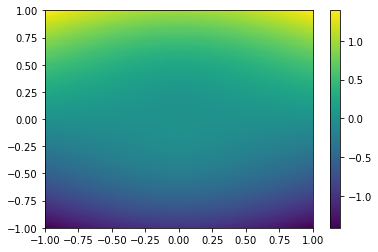

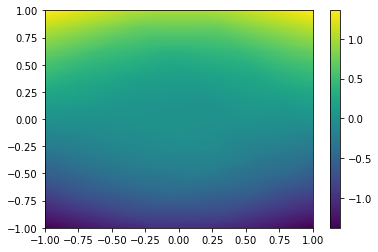

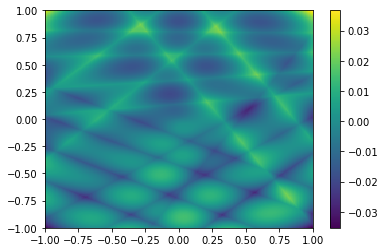

In [22]:
y_test_2d = y_test.reshape((N_test_1d,N_test_1d))
y_pred_2d = y_pred.reshape((N_test_1d,N_test_1d))

plt.figure()
plt.pcolormesh(X_test_2d, Y_test_2d, y_test_2d)
plt.colorbar()

plt.figure()
plt.pcolormesh(X_test_2d, Y_test_2d, y_pred_2d)
plt.colorbar()

plt.figure()
plt.pcolormesh(X_test_2d, Y_test_2d, y_test_2d - y_pred_2d)
plt.colorbar()

100000 max q 0.3612968630051589
200000 max q 0.3833724143438851
300000 max q 0.3838681017323774
400000 max q 0.3838789824417029
500000 max q 0.38387922115718404
100000 max q 0.3662732170188874
200000 max q 0.3966735429090272
300000 max q 0.39803462825080044
400000 max q 0.3980962011442777
500000 max q 0.39809895062906714


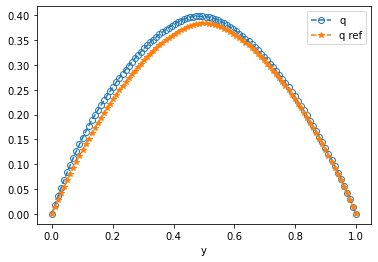

In [24]:
def nn_flux(net, q, dq):
    
    x = np.vstack((q, dq)).T
    
    permeability = net(torch.from_numpy(x.astype(np.float32))).detach().numpy().flatten()
    
    return permeability



L = 1.0
Ny = 100
yy = np.linspace(0.0, L, Ny)
f = 6*(1-2*yy)**2 - 2*(yy - yy**2)*(1 - 2*yy)**2 + 2*(yy - yy**2)**2 + 2 
q_sol = -yy*(yy - 1)
dbc = np.array([0.0, 0.0]) 

MODEL = "exp_nummodel"

if MODEL == "exp_nummodel":
    
    model = lambda q, yy, res : nummodel_flux(ref_flux, q, yy, res)
    yy, t_data_ref, q_data_ref = explicit_solve(model, f, dbc, dt = 2.0e-6, Nt = 500000, save_every = 100000, L = L)
    
    nn_model = partial(nn_flux, net)
    model = lambda q, yy, res : nummodel_flux(nn_model, q, yy, res)
    yy, t_data, q_data = explicit_solve(model, f, dbc, dt = 2.0e-6, Nt = 500000, save_every = 100000, L = L)

else:
    print("ERROR")


plt.figure()
plt.plot(yy, q_data[-1, :],  "--o", fillstyle="none", label="q")
plt.plot(yy, q_data_ref[-1, :],  "--*", label="q ref")

plt.xlabel("y")
plt.legend()
plt.show()